### Multi-task Learning
(Developed from dacon_etri_base_mod4_1.ipynb)
* 전처리 - MinMaxScaler 또는 RobustScaler 통일
* 파생변수 변경  
* 변수선정 

In [196]:
from datetime import datetime

# 현재 날짜 및 시간 가져오기
now = datetime.now()
timestamp = now.strftime("%m%d_%H%M")  # 예: 0517_1530


# ---------(submission_folder)--------- # 
# kmjng
submission_folder = '/home/user/miniconda3/envs/gpu_conda/src/lifelog-sleep-ictc-2025/minjeong/submission/'

# # kmjng-nb
# submission_folder = 'C:/Users/minjeong/Documents/my_env/env1/src/lifelog-sleep-ictc-2025/minjeong/submission'

# # mei 
# submission_folder = 'C:/Users/EC21RNC/works/.venv/src/mei/lifelog/submission/'


# ------------(base_folder)------------ # 

# # mei 
# base_folder = 'C:/Users/EC21RNC/works/.venv/src/mei/lifelog/ETRI_lifelog_dataset'


# kmjng
base_folder =  '/home/user/miniconda3/envs/gpu_conda/src/data/ETRI_lifelog_dataset'

# # kmjng-nb
# base_folder = 'C:/Users/minjeong/Documents/my_env/env1/src/data/ETRI_lifelog_dataset'

folder = '/ch2025_data_items'


# ------------------------------ # 
data_dir = base_folder + folder 
submission_file = f'submission_final_mod5_{timestamp}.csv'



In [197]:

import numpy as np 
import pandas as pd 
import glob 
import random 
import os 
import matplotlib.pyplot as plt 
import seaborn as sns 
import ast 
import warnings
warnings.filterwarnings('ignore') 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
import torch
import tensorflow as tf 


In [198]:
# seed 고정 
SD = 42 
random.seed(SD) 
np.random.seed(SD) 
os.environ['PYTHONHASHSEED'] = str(SD)
tf.random.set_seed(SD)  # TensorFlow 시드 설정

# 파일 경로 설정 - VSCode 상대경로로 변경
# 실제 경로에 맞게 수정 필요


# Parquet 파일 전체 경로 리스트 
parquet_files = glob.glob(os.path.join(data_dir, 'ch2025_*.parquet')) 

In [199]:
# 파일 이름을 키로, DataFrame을 값으로 저장할 딕셔너리 
lifelog_data = {} 

# 파일별로 읽기 
for file_path in parquet_files: 
    name = os.path.basename(file_path).replace('.parquet', '').replace('ch2025_', '') 
    lifelog_data[name] = pd.read_parquet(file_path) 
    print(f"✅ Loaded: {name}, shape = {lifelog_data[name].shape}") 

# 딕셔너리에 있는 모든 항목을 독립적인 변수로 할당 
for key, df in lifelog_data.items(): 
    globals()[f"{key}_df"] = df 

✅ Loaded: wHr, shape = (382918, 3)
✅ Loaded: mGps, shape = (800611, 3)
✅ Loaded: mScreenStatus, shape = (939653, 3)
✅ Loaded: mACStatus, shape = (939896, 3)
✅ Loaded: mActivity, shape = (961062, 3)
✅ Loaded: mBle, shape = (21830, 3)
✅ Loaded: mWifi, shape = (76336, 3)
✅ Loaded: mLight, shape = (96258, 3)
✅ Loaded: mAmbience, shape = (476577, 3)
✅ Loaded: wLight, shape = (633741, 3)
✅ Loaded: wPedo, shape = (748100, 9)
✅ Loaded: mUsageStats, shape = (45197, 3)


In [200]:
# 메트릭스 파일 읽기
metrics_train = pd.read_csv(base_folder + '/ch2025_metrics_train.csv')
sample_submission = pd.read_csv(base_folder+'/ch2025_submission_sample.csv')

# ✅ 기준 쌍 (subject_id, lifelog_date) 
sample_submission['lifelog_date'] = pd.to_datetime(sample_submission['lifelog_date']) 
test_keys = set(zip(sample_submission['subject_id'], sample_submission['lifelog_date'].dt.date)) 

# ✅ DataFrame 별 timestamp 컬럼 수동 지정 
dataframes = { 
    'mACStatus': (mACStatus_df, 'timestamp'), 
    'mActivity': (mActivity_df, 'timestamp'), 
    'mAmbience': (mAmbience_df, 'timestamp'), 
    'mBle': (mBle_df, 'timestamp'), 
    'mGps': (mGps_df, 'timestamp'), 
    'mLight': (mLight_df, 'timestamp'), 
    'mScreenStatus': (mScreenStatus_df, 'timestamp'), 
    'mUsageStats': (mUsageStats_df, 'timestamp'), 
    'mWifi': (mWifi_df, 'timestamp'), 
    'wHr': (wHr_df, 'timestamp'), 
    'wLight': (wLight_df, 'timestamp'), 
    'wPedo': (wPedo_df, 'timestamp'), 
} 

In [201]:
# ✅ 분리 함수 
def split_test_train(df, subject_col='subject_id', timestamp_col='timestamp'): 
    df[timestamp_col] = pd.to_datetime(df[timestamp_col], errors='coerce') 
    df = df.dropna(subset=[timestamp_col]) 
    df['date_only'] = df[timestamp_col].dt.date 
    df['key'] = list(zip(df[subject_col], df['date_only'])) 
    test_df = df[df['key'].isin(test_keys)].drop(columns=['date_only', 'key']) 
    train_df = df[~df['key'].isin(test_keys)].drop(columns=['date_only', 'key']) 
    return test_df, train_df 


In [202]:
# ✅ 결과 저장 
for name, (df, ts_col) in dataframes.items(): 
    print(f"⏳ {name} 분리 중...") 
    test_df, train_df = split_test_train(df.copy(), subject_col='subject_id', timestamp_col=ts_col) 
    globals()[f"{name}_test"] = test_df 
    globals()[f"{name}_train"] = train_df 
    print(f"✅ {name}_test → {test_df.shape}, {name}_train → {train_df.shape}") 

⏳ mACStatus 분리 중...
✅ mACStatus_test → (335849, 3), mACStatus_train → (604047, 3)
⏳ mActivity 분리 중...
✅ mActivity_test → (343579, 3), mActivity_train → (617483, 3)
⏳ mAmbience 분리 중...
✅ mAmbience_test → (170453, 3), mAmbience_train → (306124, 3)
⏳ mBle 분리 중...
✅ mBle_test → (8140, 3), mBle_train → (13690, 3)
⏳ mGps 분리 중...
✅ mGps_test → (287386, 3), mGps_train → (513225, 3)
⏳ mLight 분리 중...
✅ mLight_test → (34439, 3), mLight_train → (61819, 3)
⏳ mScreenStatus 분리 중...
✅ mScreenStatus_test → (336160, 3), mScreenStatus_train → (603493, 3)
⏳ mUsageStats 분리 중...
✅ mUsageStats_test → (16499, 3), mUsageStats_train → (28698, 3)
⏳ mWifi 분리 중...
✅ mWifi_test → (27467, 3), mWifi_train → (48869, 3)
⏳ wHr 분리 중...
✅ wHr_test → (143311, 3), wHr_train → (239607, 3)
⏳ wLight 분리 중...
✅ wLight_test → (233809, 3), wLight_train → (399932, 3)
⏳ wPedo 분리 중...
✅ wPedo_test → (288832, 9), wPedo_train → (459268, 9)


In [203]:
def process_mACStatus(df): 
    df['timestamp'] = pd.to_datetime(df['timestamp']) 
    df['date'] = df['timestamp'].dt.date 
    df = df.sort_values(['subject_id', 'timestamp']) 
    results = [] 
    for (subj, date), group in df.groupby(['subject_id', 'date']): 
        status = group['m_charging'].values # 0/1 상태 
        times = group['timestamp'].values # 충전 상태 비율 
        ratio_charging = status.mean() 
        # 상태 전이 횟수 
        transitions = (status[1:] != status[:-1]).sum() 
        # 연속된 1 상태 길이들 
        lengths = [] 
        current_len = 0 
        for val in status: 
            if val == 1: 
                current_len += 1 
            elif current_len > 0: 
                lengths.append(current_len) 
                current_len = 0 
        if current_len > 0: 
            lengths.append(current_len) 
        avg_charging_duration = np.mean(lengths) if lengths else 0 
        max_charging_duration = np.max(lengths) if lengths else 0 
        results.append({ 
            'subject_id': subj, 
            'date': date, 
            'charging_ratio': ratio_charging, 
            'charging_transitions': transitions, 
            'avg_charging_duration': avg_charging_duration, 
            'max_charging_duration': max_charging_duration, 
        }) 
    return pd.DataFrame(results) 

mACStatus_df2 = process_mACStatus(mACStatus_df) 

In [204]:
def process_mActivity(df): 
    df['timestamp'] = pd.to_datetime(df['timestamp']) 
    df['date'] = df['timestamp'].dt.date 
    summary = [] 
    for (subj, date), group in df.groupby(['subject_id', 'date']): 
        counts = group['m_activity'].value_counts(normalize=True) # 비율 
        row = {'subject_id': subj, 'date': date} 
        # 0~8 비율 저장 
        for i in range(9): 
            row[f'activity_{i}_ratio'] = counts.get(i, 0) 
        # 주요 활동 정보 
        row['dominant_activity'] = group['m_activity'].mode()[0] 
        row['num_unique_activities'] = group['m_activity'].nunique() 
        summary.append(row) 
    return pd.DataFrame(summary) 

mActivity_df2 = process_mActivity(mActivity_df) 

In [205]:
mActivity_df2['activity_2_ratio'].value_counts(ascending=False)

activity_2_ratio
0    700
Name: count, dtype: int64

In [206]:
mActivity_df2.drop(columns=['activity_2_ratio', 'activity_5_ratio','activity_6_ratio'], axis=1, inplace=True) # 2번('bicycle'), 5번('tilting'), 6번 모두 0

In [207]:
mActivity_df2.head(3)

,subject_id,date,activity_0_ratio,activity_1_ratio,activity_3_ratio,activity_4_ratio,activity_7_ratio,activity_8_ratio,dominant_activity,num_unique_activities
0,id01,2024-06-26,0.125176,0.001406,0.672293,0.157525,0.043601,0.0,3,5
1,id01,2024-06-27,0.146528,0.000000,0.611111,0.220833,0.021528,0.0,3,4
2,id01,2024-06-28,0.111806,0.000694,0.861806,0.000694,0.025000,0.0,3,5


In [208]:
# 지정된 10개 라벨 
top_10_labels = [ 
    "Inside, small room", "Speech", "Silence", "Music", "Narration, monologue", 
    "Child speech, kid speaking", "Conversation", "Speech synthesizer", "Shout", "Babbling" 
] 

def process_mAmbience_top10(df): 
    df = df.copy() 
    df['timestamp'] = pd.to_datetime(df['timestamp']) 
    df['date'] = df['timestamp'].dt.date 
    # 초기화 
    for label in top_10_labels + ['others']: 
        df[label] = 0.0 
    for idx, row in df.iterrows(): 
        parsed = ast.literal_eval(row['m_ambience']) if isinstance(row['m_ambience'], str) else row['m_ambience'] 
        others_prob = 0.0 
        for label, prob in parsed: 
            prob = float(prob) 
            if label in top_10_labels: 
                df.at[idx, label] = prob 
            else: 
                others_prob += prob 
        df.at[idx, 'others'] = others_prob 
    return df.drop(columns=['m_ambience']) 

mAmbience_df2= process_mAmbience_top10(mAmbience_df) 

In [209]:
def summarize_mAmbience_daily(df): 
    prob_cols = [col for col in df.columns if col not in ['subject_id', 'timestamp', 'date']] 
    # 하루 단위로 평균값 요약 
    daily_summary = df.groupby(['subject_id', 'date'])[prob_cols].mean().reset_index() 
    return daily_summary 

mAmbience_df2 = summarize_mAmbience_daily(mAmbience_df2) 


### mBle (블루투스 장치)
> 이 데이터는 위치 기반 행동 패턴, 사회적 상호작용, 일상 루틴 분석에 유용 
* RSSI = 신호 강도 (Received Signal Strength Indicator): 
 값이 0에 가까울수록 장치가 가까이 있음 (-30dBm > -70dBm)  
* device_class_0_ratio (0~1):  
 전체 감지된 장치 중 "클래스 0" 장치의 비율  
 보통 스마트폰, 태블릿 등 개인 장치    
* device_class_others_ratio (0~1):  
기타 장치들의 비율 (헤드폰, 스피커, IoT 기기 등)   
(--)   
device_class_0_ratio가 높으면 → 사람들(스마트폰) 근처에 많이 있었음  
device_class_others_ratio가 높으면 → IoT가 많은 환경 (카페, 사무실 등) 

In [210]:
def process_mBle(df): 
    df = df.copy() 
    df['timestamp'] = pd.to_datetime(df['timestamp']) 
    df['date'] = df['timestamp'].dt.date 
    features = [] 
    for idx, row in df.iterrows(): 
        entry = ast.literal_eval(row['m_ble']) if isinstance(row['m_ble'], str) else row['m_ble'] 
        rssi_list = [] 
        class_0_cnt = 0 
        class_other_cnt = 0 
        class_7936_cnt = 0  # 추가
        class_1796_cnt = 0  # 추가


        for device in entry: 
            try: 
                rssi = int(device['rssi']) 
                rssi_list.append(rssi) 
                device_class = str(device['device_class'])
                if device_class == '0': 
                    class_0_cnt += 1 
                elif device_class == '7936':  # 추가
                    class_7936_cnt += 1
                elif device_class == '1796':  # 추가
                    class_1796_cnt += 1
                else: 
                    class_other_cnt += 1 
            except: 
                continue 

        feature = { 
            'subject_id': row['subject_id'], 
            'date': row['date'], 
            'device_class_0_cnt': class_0_cnt, 
            'device_class_others_cnt': class_other_cnt, 
            'device_class_7936_cnt': class_7936_cnt,  # 추가
            'device_class_1796_cnt': class_1796_cnt,  # 추가
            'device_count': len(rssi_list), 
            'rssi_mean': np.mean(rssi_list) if rssi_list else np.nan, 
            'rssi_min': np.min(rssi_list) if rssi_list else np.nan, 
            'rssi_max': np.max(rssi_list) if rssi_list else np.nan, 
        } 
        features.append(feature) 
    return pd.DataFrame(features)

In [211]:
def summarize_mBle_daily(df): 
    df = process_mBle(df) 
    grouped = df.groupby(['subject_id', 'date']).agg({ 
        'device_class_0_cnt': 'sum', 
        'device_class_others_cnt': 'sum', 
        'device_class_7936_cnt': 'sum',  # 추가
        'device_class_1796_cnt': 'sum',  # 추가
        'rssi_mean': 'mean', 
        'rssi_min': 'min', 
        'rssi_max': 'max', 
    }).reset_index() 
    
    total_cnt = grouped['device_class_0_cnt'] + grouped['device_class_others_cnt'] + grouped['device_class_7936_cnt'] + grouped['device_class_1796_cnt']
    grouped['device_class_0_ratio'] = grouped['device_class_0_cnt'] / total_cnt.replace(0, np.nan) 
    grouped['device_class_others_ratio'] = grouped['device_class_others_cnt'] / total_cnt.replace(0, np.nan) 
    grouped['device_class_7936_ratio'] = grouped['device_class_7936_cnt'] / total_cnt.replace(0, np.nan)  # 추가
    grouped['device_class_1796_ratio'] = grouped['device_class_1796_cnt'] / total_cnt.replace(0, np.nan)  # 추가
    
    grouped.drop(columns=['device_class_0_cnt', 'device_class_others_cnt', 'device_class_7936_cnt', 'device_class_1796_cnt'], inplace=True) 
    return grouped

mBle_df2 = summarize_mBle_daily(mBle_df) 


In [212]:
print(mBle_df.head(4))
print(mBle_df['m_ble'][0][0])
print(mBle_df2.columns)


all_classes = [device['device_class'] 
               for ble_array in mBle_df['m_ble'] if ble_array is not None
               for device in ble_array]

device_counts = pd.Series(all_classes).value_counts()
print(device_counts)

  subject_id           timestamp  \
0       id01 2024-06-26 12:13:00   
1       id01 2024-06-26 12:23:00   
2       id01 2024-06-26 12:33:00   
3       id01 2024-06-26 13:23:00   

                                               m_ble  
0  [{'address': '00:15:7C:11:80:8D', 'device_clas...  
1  [{'address': '0A:B1:26:4D:76:21', 'device_clas...  
2  [{'address': '04:F5:AE:39:95:E0', 'device_clas...  
3  [{'address': '06:C0:D2:6D:9F:69', 'device_clas...  
{'address': '00:15:7C:11:80:8D', 'device_class': '0', 'rssi': -82}
Index(['subject_id', 'date', 'rssi_mean', 'rssi_min', 'rssi_max',
       'device_class_0_ratio', 'device_class_others_ratio',
       'device_class_7936_ratio', 'device_class_1796_ratio'],
      dtype='object')
0       385700
7936     45002
1796      2524
          1144
1084       967
524        662
1060       443
1280       382
284        146
1024        30
1408        15
1344        15
1064         9
1028         5
1044         5
2324         3
1048         1
256         

### (*) GPS 값

In [213]:
def process_mGps(df): 
    df = df.copy() 
    df['timestamp'] = pd.to_datetime(df['timestamp']) 
    df['date'] = df['timestamp'].dt.date 
    features = [] 
    for idx, row in df.iterrows(): 
        gps_list = ast.literal_eval(row['m_gps']) if isinstance(row['m_gps'], str) else row['m_gps'] 
        altitudes = [] 
        latitudes = [] 
        longitudes = [] 
        speeds = [] 
        for entry in gps_list: 
            try: 
                altitudes.append(float(entry['altitude'])) 
                latitudes.append(float(entry['latitude'])) 
                longitudes.append(float(entry['longitude'])) 
                speeds.append(float(entry['speed'])) 
            except: 
                continue 
        features.append({ 
            'subject_id': row['subject_id'], 
            'date': row['date'], 
            'altitude_mean': np.mean(altitudes) if altitudes else np.nan, 
            'latitude_std': np.std(latitudes) if latitudes else np.nan, 
            'longitude_std': np.std(longitudes) if longitudes else np.nan, 
            'speed_mean': np.mean(speeds) if speeds else np.nan, 
            'speed_max': np.max(speeds) if speeds else np.nan, 
            'speed_std': np.std(speeds) if speeds else np.nan, 
        }) 
    return pd.DataFrame(features) 

In [214]:
m_Gps_df2 = process_mGps(mGps_df) 
m_Gps_df2 = m_Gps_df2.groupby(['subject_id', 'date']).agg({ 
    'altitude_mean': 'mean', 
    'latitude_std': 'mean', 
    'longitude_std': 'mean', 
    'speed_mean': 'mean', 
    'speed_max': 'max', 
    'speed_std': 'mean' 
}).reset_index() 

### (*) 주변 빛 (mobile 측정)

In [215]:
def process_mLight(df): 
    df = df.copy() 
    df['timestamp'] = pd.to_datetime(df['timestamp']) 
    df['date'] = df['timestamp'].dt.date 
    df['hour'] = df['timestamp'].dt.hour 
    # 밤(22~05시), 낮(06~21시) 구분 
    df['is_night'] = df['hour'].apply(lambda h: h >= 22 or h < 6) 
    # 하루 단위 요약 
    daily = df.groupby(['subject_id', 'date']).agg( 
        light_mean=('m_light', 'mean'), 
        light_std=('m_light', 'std'), 
        light_max=('m_light', 'max'), 
        light_min=('m_light', 'min'), 
        light_night_mean=('m_light', lambda x: x[df.loc[x.index, 'is_night']].mean()), 
        light_day_mean=('m_light', lambda x: x[~df.loc[x.index, 'is_night']].mean()), 
        light_night_ratio=('is_night', 'mean') # 밤 시간 측정 비율 
    ).reset_index() 
    return daily 

mLight_df2 = process_mLight(mLight_df) 

### (*) 스마트폰 화면 사용 중 여부 

- 추가 파생변수: 밤 시간 사용, 낮 시간 사용 여부 

In [261]:
def process_mScreenStatus(df): 
    df = df.copy() 
    df['timestamp'] = pd.to_datetime(df['timestamp']) 
    df['date'] = df['timestamp'].dt.date 
    df['hour'] = df['timestamp'].dt.hour  # 시간 정보 추가
    
    features = [] 
    for (subj, date), group in df.groupby(['subject_id', 'date']): 
        status = group['m_screen_use'].values 
        hours = group['hour'].values  # 해당 그룹의 시간 정보
        
        # 기존 특성들
        ratio_on = status.mean() 
        transitions = (status[1:] != status[:-1]).sum() 
        
        # 연속된 1 상태 길이들 
        durations = [] 
        current = 0 
        for val in status: 
            if val == 1: 
                current += 1 
            elif current > 0: 
                durations.append(current) 
                current = 0 
        if current > 0: 
            durations.append(current) 
            
        # 시간대별 사용 패턴 추가
        # 밤 시간대 (22시-05시) 스크린 사용
        night_mask = (hours >= 22) | (hours <= 5)
        night_screen_usage = status[night_mask].mean() if night_mask.any() else 0
        
        # 낮 시간대 (06시-21시) 스크린 사용  
        day_mask = (hours >= 6) & (hours <= 21)
        day_screen_usage = status[day_mask].mean() if day_mask.any() else 0
        
        features.append({ 
            'subject_id': subj, 
            'date': date, 
            'screen_on_ratio': ratio_on, 
            'screen_on_transitions': transitions, 
            'screen_on_duration_avg': np.mean(durations) if durations else 0, 
            'screen_on_duration_max': np.max(durations) if durations else 0,
            'night_screen_usage': night_screen_usage,  # 밤시간 스크린 사용 비율
            'day_screen_usage': day_screen_usage,      # 낮시간 스크린 사용 비율
        }) 
    return pd.DataFrame(features)

mScreenStatus_df2 = process_mScreenStatus(mScreenStatus_df) 


In [259]:
# 분포가 너무 치우쳐있는지 확인
print(mScreenStatus_df['m_screen_use'].value_counts())
# 만약 0이 99%, 1이 1%라면 정보량이 적을 수 있음

m_screen_use
0    725047
1    214606
Name: count, dtype: int64


In [262]:
mScreenStatus_df2.head(4)

,subject_id,date,screen_on_ratio,screen_on_transitions,screen_on_duration_avg,screen_on_duration_max,night_screen_usage,day_screen_usage
0,id01,2024-06-26,0.295359,54,7.777778,60,0.552632,0.246231
1,id01,2024-06-27,0.365734,82,12.756098,79,0.161702,0.465625
2,id01,2024-06-28,0.319718,90,10.088889,51,0.091489,0.432632
3,id01,2024-06-29,0.237857,66,10.090909,82,0.008511,0.353763


In [217]:
mUsageStats_df.head(2)

,subject_id,timestamp,m_usage_stats
0,id01,2024-06-26 13:00:00,"[{'app_name': ' 캐시워크', 'total_time': 69}, {'ap..."
1,id01,2024-06-26 13:10:00,"[{'app_name': '통화', 'total_time': 26419}, {'ap..."


In [218]:
# 모든 앱 데이터를 하나의 리스트로 합치기 (추가)
all_apps = []
for stats in mUsageStats_df['m_usage_stats']:
    all_apps.extend(stats)  # numpy array든 list든 extend로 합치기

# DataFrame으로 변환
app_df = pd.DataFrame(all_apps)
top_10 = app_df.groupby('app_name')['total_time'].sum().sort_values(ascending=False).head(10)

print("가장 많이 사용된 앱 TOP 10:")
for i, (app, time) in enumerate(top_10.items(), 1):
    print(f"{i}. {app}: {time}분")



가장 많이 사용된 앱 TOP 10:
1. One UI 홈: 4655575663분
2. 시스템 UI: 2598865909분
3. 카카오톡: 2408771919분
4. NAVER: 1156302340분
5. YouTube: 806269206분
6.  ✝️성경일독Q: 778709744분
7.  캐시워크: 555842806분
8. Instagram: 554532193분
9. 통화: 448883450분
10. Microsoft Launcher: 440910412분


In [219]:
# top_20 = app_df.groupby('app_name')['total_time'].sum().sort_values(ascending=False).head(20)
# top_20.index

# # 기존 top_apps
# # top_apps = [ 
# #     'One UI 홈', '카카오톡', '시스템 UI', 'NAVER', '캐시워크', 
# #     '성경일독Q', 'YouTube', '통화', '메시지', '타임스프레드', 'Instagram'
# # ] 
# top_apps = top_20.index

# def process_mUsageStats(df): 
#     df = df.copy() 
#     df['timestamp'] = pd.to_datetime(df['timestamp']) 
#     df['date'] = df['timestamp'].dt.date 
#     features = [] 
#     for (subj, date), group in df.groupby(['subject_id', 'date']): 
#         app_time = {app: 0 for app in top_apps} 
#         others_time = 0 
#         for row in group['m_usage_stats']: 
#             parsed = ast.literal_eval(row) if isinstance(row, str) else row 
#             for entry in parsed: 
#                 app = entry.get('app_name') 
#                 time = entry.get('total_time', 0) 
#                 if app in top_apps: 
#                     app_time[app] += int(time) 
#                 else: 
#                     others_time += int(time) 
#         feature = { 
#             'subject_id': subj, 
#             'date': date, 
#             'others_time': others_time 
#         } 
#         # 각 앱별 컬럼 추가 
#         feature.update({f'{app}_time': app_time[app] for app in top_apps}) 
#         features.append(feature) 
#     return pd.DataFrame(features) 

# mUsageStats_df2 = process_mUsageStats(mUsageStats_df) 

In [220]:
# 앱 사용 시간 (합계)
mUsageStats_df3 = mUsageStats_df.copy() 
# 방법 1: 기존 DataFrame에 새로운 컬럼 추가
def calculate_total_usage_time(usage_stats):
    """m_usage_stats에서 모든 앱의 total_time 합계 계산"""
    total_time = 0
    for app in usage_stats:
        total_time += app['total_time']
    return total_time

# m_usage_time 컬럼 추가
mUsageStats_df3['m_usage_time'] = mUsageStats_df3['m_usage_stats'].apply(calculate_total_usage_time)

# # 결과 확인
# print("새로운 컬럼이 추가된 DataFrame:")
# print(mUsageStats_df3[['subject_id', 'timestamp', 'm_usage_time']].head())


# # 전체 구조 확인
# print(f"\nDataFrame shape: {mUsageStats_df3.shape}")
# print(f"Columns: {mUsageStats_df3.columns.tolist()}")

mUsageStats_df3 = mUsageStats_df3[['subject_id', 'timestamp', 'm_usage_time']]

# 간단한 방법: 날짜별 사용시간 합계
mUsageStats_df3['date'] = pd.to_datetime(mUsageStats_df3['timestamp']).dt.date

# 날짜별 합계 계산
mUsageStats_df3 = mUsageStats_df3.groupby(['subject_id', 'date'])['m_usage_time'].sum().reset_index()



In [221]:
mUsageStats_df3.head(2)

,subject_id,date,m_usage_time
0,id01,2024-06-26,25418119
1,id01,2024-06-27,54102878


### (*) Wifi 신호   
* wifi_rssi_mean(평균 수신 신호 세기(RSSI)): 수면 중 움직임이 적을 때 신호 변화가 작아질 수 있음.   
* wifi_rssi_min(최소 수신 신호 세기): 환경적 변화(예: 몸의 이동, 장애물 등)에 민감. 수면 중 큰 움직임(뒤척임 등) 감지에 활용 가능성  
* wifi_detected_cnt(WiFi 신호 감지 횟수): 스마트폰 등 단말의 네트워크 이벤트(접속/해제, 트래픽 등) 빈도와 수면/각성 상태가 밀접히 연관됨  

In [297]:
mWifi_df.head(3)

,subject_id,timestamp,m_wifi
0,id01,2024-06-26 12:03:00,"[{'bssid': 'a0:0f:37:9a:5d:8b', 'rssi': -78}, ..."
1,id01,2024-06-26 12:13:00,"[{'bssid': 'a0:0f:37:9a:5d:8b', 'rssi': -79}, ..."
2,id01,2024-06-26 12:23:00,"[{'bssid': '10:e3:c7:0a:74:d1', 'rssi': -78}, ..."


In [298]:
mWifi_df.m_wifi[0][0]

{'bssid': 'a0:0f:37:9a:5d:8b', 'rssi': -78}

In [360]:
def process_mWifi(df): 
    df = df.copy() 
    df['timestamp'] = pd.to_datetime(df['timestamp']) 
    df['date'] = df['timestamp'].dt.date 
    df['hour'] = df['timestamp'].dt.hour
    
    results = [] 
    for (subj, date), group in df.groupby(['subject_id', 'date']): 
        # 시간대별로 데이터 분리
        afternoon_data = group[(group['hour'] >= 12) & (group['hour'] < 18)]  # 12-18시
        night_data = group[(group['hour'] >= 18) & (group['hour'] < 24)]      # 18-24시  
        midnight_data = group[(group['hour'] >= 0) & (group['hour'] < 6)]     # 0-6시
        
        def extract_rssi(data):
            rssi_list = []
            for row in data['m_wifi']:
                parsed = ast.literal_eval(row) if isinstance(row, str) else row 
                for ap in parsed: 
                    try: 
                        rssi = int(ap['rssi']) 
                        rssi_list.append(rssi) 
                    except: 
                        continue 
            return rssi_list
        
        # 각 시간대별 RSSI 추출
        afternoon_rssi = extract_rssi(afternoon_data)
        night_rssi = extract_rssi(night_data)
        midnight_rssi = extract_rssi(midnight_data)
        
        results.append({ 
            'subject_id': subj, 
            'date': date, 
            # 오후 (12-18시)
            'afternoon_wifi_rssi_mean': np.mean(afternoon_rssi) if afternoon_rssi else np.nan,
            'afternoon_wifi_rssi_std': np.std(afternoon_rssi) if afternoon_rssi else np.nan,
            'afternoon_wifi_detected_cnt': len(afternoon_rssi),
            
            # 밤 (18-24시)  
            'night_wifi_rssi_mean': np.mean(night_rssi) if night_rssi else np.nan,
            'night_wifi_rssi_std': np.std(night_rssi) if night_rssi else np.nan,
            'night_wifi_detected_cnt': len(night_rssi),
            
            # # 자정 (0-6시)
            # 'midnight_wifi_rssi_mean': np.mean(midnight_rssi) if midnight_rssi else np.nan,
            # 'midnight_wifi_rssi_std': np.std(midnight_rssi) if midnight_rssi else np.nan,
            # 'midnight_wifi_detected_cnt': len(midnight_rssi),
        }) 
    return pd.DataFrame(results) 

mWifi_df2 = process_mWifi(mWifi_df) 
mWifi_df2

,subject_id,date,afternoon_wifi_rssi_mean,afternoon_wifi_rssi_std,afternoon_wifi_detected_cnt,night_wifi_rssi_mean,night_wifi_rssi_std,night_wifi_detected_cnt
0,id01,2024-06-26,-72.036217,12.386738,497,-68.208696,14.965465,460
1,id01,2024-06-27,-73.362229,12.714125,323,-67.161585,18.331004,328
2,id01,2024-06-28,-72.929260,12.480267,311,-65.041935,17.819929,310
3,id01,2024-06-29,-71.326034,14.117021,411,-64.490272,19.074116,257
4,id01,2024-06-30,-73.211581,12.737271,449,-63.260417,18.910743,288
...,...,...,...,...,...,...,...,...
680,id10,2024-09-21,-71.640227,13.722390,353,-72.092742,12.637768,496
681,id10,2024-09-22,-72.205418,13.282510,443,-69.657841,13.578205,491
682,id10,2024-09-24,-70.651786,13.732593,560,-73.130604,11.434213,513
683,id10,2024-09-25,-66.057377,16.627697,732,-71.866221,11.839598,299


In [359]:
mWifi_df2.midnight_wifi_rssi_std.isnull().sum()

48

In [ ]:
# 기존 코드 
# def process_mWifi(df): 
#     df = df.copy() 
#     df['timestamp'] = pd.to_datetime(df['timestamp']) 
#     df['date'] = df['timestamp'].dt.date 
#     results = [] 
#     for (subj, date), group in df.groupby(['subject_id', 'date']): 
#         rssi_all = [] 
#         for row in group['m_wifi']: 
#             parsed = ast.literal_eval(row) if isinstance(row, str) else row 
#             for ap in parsed: 
#                 try: 
#                     rssi = int(ap['rssi']) 
#                     rssi_all.append(rssi) 
#                 except: 
#                     continue 
#         results.append({ 
#             'subject_id': subj, 
#             'date': date, 
#             'wifi_rssi_mean': np.mean(rssi_all) if rssi_all else np.nan, 
#             'wifi_rssi_std': np.std(rssi_all) if rssi_all else np.nan,  # 표준편차 추가 
#             'wifi_rssi_min': np.min(rssi_all) if rssi_all else np.nan,  
#             'wifi_rssi_max': np.max(rssi_all) if rssi_all else np.nan, 
#             'wifi_detected_cnt': len(rssi_all) 
#         }) 
#     return pd.DataFrame(results) 

# mWifi_df2 = process_mWifi(mWifi_df) 
# mWifi_df2

* 심박수

In [223]:

def get_time_block(hour): 
    if 0 <= hour < 6: 
        return 'early_morning' 
    elif 6 <= hour < 12: 
        return 'morning' 
    elif 12 <= hour < 18: 
        return 'afternoon' 
    else: 
        return 'evening' 

def process_wHr_by_timeblock(df): 
    df = df.copy() 
    df['timestamp'] = pd.to_datetime(df['timestamp']) 
    df['date'] = df['timestamp'].dt.date 
    df['block'] = df['timestamp'].dt.hour.map(get_time_block) 
    results = [] 
    for (subj, date), group in df.groupby(['subject_id', 'date']): 
        block_stats = {'subject_id': subj, 'date': date} 
        for block, block_group in group.groupby('block'): 
            hr_all = [] 
            for row in block_group['heart_rate']: 
                parsed = ast.literal_eval(row) if isinstance(row, str) else row 
                hr_all.extend([int(h) for h in parsed if h is not None]) 
            if not hr_all: 
                continue 
            above_100 = [hr for hr in hr_all if hr > 100] 
            block_stats[f'hr_{block}_mean'] = np.mean(hr_all) 
            block_stats[f'hr_{block}_std'] = np.std(hr_all) 
            block_stats[f'hr_{block}_max'] = np.max(hr_all) 
            block_stats[f'hr_{block}_min'] = np.min(hr_all) 
            block_stats[f'hr_{block}_above_100_ratio'] = len(above_100) / len(hr_all) 
        results.append(block_stats) 
    return pd.DataFrame(results) 

wHr_df2 = process_wHr_by_timeblock(wHr_df) 

# 결측 많은 피쳐 드롭 
drop_cols = [ 'hr_early_morning_mean',
   'hr_early_morning_std',
   'hr_early_morning_max',
   'hr_early_morning_min',
   'hr_early_morning_above_100_ratio']

wHr_df2.drop(columns=drop_cols, axis=1, inplace=True) # 드롭 


* 심박수 파생변수 추가   
> 밤-낮 심박수 차이, 정상심박수 비율, 심박수 안정성

In [224]:
import ast 

def get_time_block_no_early(hour): 
    if 6 <= hour < 12: 
        return 'morning' 
    elif 12 <= hour < 18: 
        return 'afternoon' 
    elif 18 <= hour < 24:
        return 'evening'
    else:
        return None

def process_wHr_with_features_only(df): 
    df = df.copy() 
    df['timestamp'] = pd.to_datetime(df['timestamp']) 
    df['date'] = df['timestamp'].dt.date 
    df['block'] = df['timestamp'].dt.hour.map(get_time_block_no_early) 
    
    results = [] 
    for (subj, date), group in df.groupby(['subject_id', 'date']): 
        block_stats = {'subject_id': subj, 'date': date} 
        
        # 전체 일일 심박수 데이터 수집
        all_day_hr = []
        day_hr = []    # 낮 (6-18시): morning + afternoon
        night_hr = []  # 밤 (18-24시): evening만
        
        valid_group = group[group['block'].notna()]
        
        for block, block_group in valid_group.groupby('block'): 
            hr_all = [] 
            for row in block_group['heart_rate']: 
                parsed = ast.literal_eval(row) if isinstance(row, str) else row 
                hr_all.extend([int(h) for h in parsed if h is not None]) 
            
            if not hr_all: 
                continue 
            
            all_day_hr.extend(hr_all)
            
            # 낮/밤 분류만 하고 시간대별 통계는 제거
            if block in ['morning', 'afternoon']:
                day_hr.extend(hr_all)
            elif block == 'evening':
                night_hr.extend(hr_all)
        
        # 파생변수 3개
        if day_hr and night_hr:
            block_stats['day_night_hr_diff'] = np.mean(day_hr) - np.mean(night_hr)
        else:
            block_stats['day_night_hr_diff'] = np.nan
        
        if all_day_hr:
            normal_hr = [hr for hr in all_day_hr if 60 <= hr <= 100]
            block_stats['normal_hr_ratio'] = len(normal_hr) / len(all_day_hr)
        else:
            block_stats['normal_hr_ratio'] = np.nan
        
        if all_day_hr and len(all_day_hr) > 1:
            hr_mean = np.mean(all_day_hr)
            hr_std = np.std(all_day_hr)
            block_stats['hr_stability'] = hr_std / hr_mean if hr_mean > 0 else np.nan
        else:
            block_stats['hr_stability'] = np.nan
            
        results.append(block_stats) 
    
    return pd.DataFrame(results) 

# 실행
wHr_df3 = process_wHr_with_features_only(wHr_df)
# print(wHr_df3.columns.tolist())

wHr_df3 = pd.merge(wHr_df2, wHr_df3, on=['subject_id', 'date'], how='inner')


In [225]:
wHr_df3.head(3)

,subject_id,date,hr_afternoon_mean,hr_afternoon_std,hr_afternoon_max,hr_afternoon_min,hr_afternoon_above_100_ratio,hr_evening_mean,hr_evening_std,hr_evening_max,hr_evening_min,hr_evening_above_100_ratio,hr_morning_mean,hr_morning_std,hr_morning_max,hr_morning_min,hr_morning_above_100_ratio,day_night_hr_diff,normal_hr_ratio,hr_stability
0,id01,2024-06-26,80.533300,12.636566,142.0,59.0,0.077268,82.476838,10.293221,124.0,59.0,0.055503,NaN,NaN,NaN,NaN,NaN,-1.943538,0.930558,0.146119
1,id01,2024-06-27,87.405165,12.296994,125.0,63.0,0.179430,83.526477,10.967673,122.0,61.0,0.082859,72.343956,10.333083,130.0,53.0,0.023445,-7.571946,0.925296,0.158047
2,id01,2024-06-28,83.013953,12.488545,135.0,55.0,0.099419,75.821333,9.176060,109.0,59.0,0.018667,78.775349,12.413443,120.0,51.0,0.072774,3.314891,0.922346,0.156781


### (*) 주변 빛 (Watch 측정)

In [226]:

def process_wLight_by_timeblock(df): 
    df = df.copy() 
    df['timestamp'] = pd.to_datetime(df['timestamp']) 
    df['date'] = df['timestamp'].dt.date 
    df['block'] = df['timestamp'].dt.hour.map(get_time_block) 
    results = [] 
    for (subj, date), group in df.groupby(['subject_id', 'date']): 
        block_stats = {'subject_id': subj, 'date': date} 
        for block, block_group in group.groupby('block'): 
            lux = block_group['w_light'].dropna().values 
            if len(lux) == 0: 
                continue 
            block_stats[f'wlight_{block}_mean'] = np.mean(lux) 
            block_stats[f'wlight_{block}_std'] = np.std(lux) 
            block_stats[f'wlight_{block}_max'] = np.max(lux) 
            block_stats[f'wlight_{block}_min'] = np.min(lux) 
        results.append(block_stats) 
    return pd.DataFrame(results) 

wLight_df2 = process_wLight_by_timeblock(wLight_df)

### (*) 걸음 수 (Watch 측정)

In [227]:
def process_wPedo(df): 
    df = df.copy() 
    df['timestamp'] = pd.to_datetime(df['timestamp']) 
    df['date'] = df['timestamp'].dt.date 
    summary = df.groupby(['subject_id', 'date']).agg({ 
        'step': 'sum', 
        'step_frequency': 'mean', 
        'distance': 'sum', 
        'speed': ['mean', 'max'], 
        'burned_calories': 'sum' 
    }).reset_index() 
    # 컬럼 이름 정리 
    summary.columns = ['subject_id', 'date', 'step_sum', 'step_frequency_mean', 'distance_sum', 'speed_mean', 'speed_max', 'burned_calories_sum'] 
    return summary 

wPedo_df2 = process_wPedo(wPedo_df) 

## [★] 데이터셋 & 모델링 준비

In [228]:
# mUsageStats_df2.columns

In [438]:

from functools import reduce 
df_list = [ 
    mACStatus_df2, 
    mActivity_df2,  
    mAmbience_df2,  
    mBle_df2, # 파생변수 추가
    m_Gps_df2, 
    mLight_df2, 
    mScreenStatus_df2, # 파생변수 추가
    mUsageStats_df3, # mUsageStats_df2, 
    mWifi_df2, # 파생변수 추가
    wHr_df3 , # wHr_df2, 
    wLight_df2, 
    wPedo_df2 
] 

merged_df = reduce(lambda left, right: pd.merge(left, right, on=['subject_id', 'date'], how='outer'), df_list) 


In [439]:
# merged_df.columns

* NaN 비율이 큰 피쳐 필터링

In [440]:
import pandas as pd

def filter_high_nan_features(df, threshold=0.5):
    """NaN 비율이 임계값 이상인 컬럼 제거 (간단 버전)"""
    nan_ratio = df.isnull().mean()  # mean()이 sum()/len()보다 간단
    keep_cols = nan_ratio[nan_ratio <= threshold].index
    
    print(f"제거된 컬럼: {df.shape[1] - len(keep_cols)}개")
    print(f"남은 컬럼: {len(keep_cols)}개")
    
    return df[keep_cols]
merged_df_filtered = filter_high_nan_features(merged_df)

제거된 컬럼: 0개
남은 컬럼: 98개


* train, test

In [441]:

# metrics_train의 lifelog_date → datetime.date 형으로 변환 
metrics_train['lifelog_date'] = pd.to_datetime(metrics_train['lifelog_date']).dt.date 

# merged_df의 date도 변환 
merged_df['date'] = pd.to_datetime(merged_df['date']).dt.date 

# 1. date 기준 정렬을 위해 metrics_train의 lifelog_date -> date로 맞추기 
metrics_train_renamed = metrics_train.rename(columns={'lifelog_date': 'date'}) 

# 2. train_df: metrics_train과 일치하는 (subject_id, date) → 라벨 포함 
train_df = pd.merge(metrics_train_renamed, merged_df, on=['subject_id', 'date'], how='inner') 

# 3. test_df: metrics_train에 없는 (subject_id, date) 
merged_keys = merged_df[['subject_id', 'date']] 
train_keys = metrics_train_renamed[['subject_id', 'date']] 
test_keys = pd.merge(merged_keys, train_keys, on=['subject_id', 'date'], how='left', indicator=True) 
test_keys = test_keys[test_keys['_merge'] == 'left_only'].drop(columns=['_merge']) 
test_df = pd.merge(test_keys, merged_df, on=['subject_id', 'date'], how='left') 


In [442]:
# ✅ MTL을 위한 추가 라이브러리
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
import numpy as np


In [443]:

# ✅ 타겟 리스트 
targets_binary = ['Q1', 'Q2', 'Q3', 'S2', 'S3'] 
target_multiclass = 'S1' 

# ✅ feature 준비 
X = train_df.drop(columns=['subject_id', 'sleep_date', 'date', 'Q1', 'Q2', 'Q3', 'S1', 'S2', 'S3']) 
X.fillna(0, inplace=True) # 결측값 처리 

test_X = test_df.drop(columns=['subject_id', 'date']) 
test_X.fillna(0, inplace=True) 


### 1. 변수 선정

In [444]:
# # feature 변수 (테스트)

# # 그룹별 중요 특성 선택
# important_features = [
#     # 스크린 관련 특성
#     'screen_on_ratio', 'screen_on_duration_avg', 'screen_on_duration_max',
    
#     # 와이파이 신호 관련 특성
#     'wifi_rssi_max', 'wifi_rssi_mean', 'wifi_detected_cnt',
    
#     # 활동 관련 특성
#     'activity_3_ratio', 'activity_4_ratio', 
    
#     # 충전 관련 특성
#     'charging_ratio', 'max_charging_duration', 'avg_charging_duration',
    
#     # 신호 관련 특성
#     'rssi_mean', 
    
#     # 빛 관련 특성
#     'light_night_mean', 'light_max', 'light_std',
    
#     # 위치/움직임 관련 특성
#     'altitude_mean', 'speed_max_x', 
    
#     # 앱 사용 관련 특성
#     '메시지_time',  'others_time', 
#     # 소음 
#     'Narration, monologue'
# ]

# # 선택된 특성만으로 데이터셋 구성
# X = X[important_features]
# test_X = test_X[important_features]

In [445]:

# 컬럼 이름에서 특수 문자 제거/변환 
def sanitize_column_names(df): 
    df.columns = ( 
        df.columns 
        .str.replace(r"[^\w]", "_", regex=True) # 특수문자 → _ 
        .str.replace(r"__+", "_", regex=True) # 연속된 _ 제거 
        .str.strip("_") # 앞뒤 _ 제거 
    ) 
    return df 

# 모든 입력에 적용 
X = sanitize_column_names(X) 
test_X = sanitize_column_names(test_X) 


# ✅ 데이터 준비
print(f"Features shape: {X.shape}")
print(f"Feature names: {list(X.columns)}")

Features shape: (450, 96)
Feature names: ['charging_ratio', 'charging_transitions', 'avg_charging_duration', 'max_charging_duration', 'activity_0_ratio', 'activity_1_ratio', 'activity_3_ratio', 'activity_4_ratio', 'activity_7_ratio', 'activity_8_ratio', 'dominant_activity', 'num_unique_activities', 'Inside_small_room', 'Speech', 'Silence', 'Music', 'Narration_monologue', 'Child_speech_kid_speaking', 'Conversation', 'Speech_synthesizer', 'Shout', 'Babbling', 'others', 'rssi_mean', 'rssi_min', 'rssi_max', 'device_class_0_ratio', 'device_class_others_ratio', 'device_class_7936_ratio', 'device_class_1796_ratio', 'altitude_mean', 'latitude_std', 'longitude_std', 'speed_mean_x', 'speed_max_x', 'speed_std', 'light_mean', 'light_std', 'light_max', 'light_min', 'light_night_mean', 'light_day_mean', 'light_night_ratio', 'screen_on_ratio', 'screen_on_transitions', 'screen_on_duration_avg', 'screen_on_duration_max', 'night_screen_usage', 'day_screen_usage', 'm_usage_time', 'afternoon_wifi_rssi_mea

In [446]:
# 이진분류 타겟들
y_binary = {}
for target in targets_binary:
    y_binary[target] = train_df[target].values
    print(f"{target} distribution: {np.bincount(y_binary[target])}")

# 다중분류 타겟 (S1) - LabelEncoder 사용
le_s1 = LabelEncoder()
y_s1 = le_s1.fit_transform(train_df[target_multiclass].values)
n_classes_s1 = len(le_s1.classes_)
print(f"S1 classes: {le_s1.classes_}, n_classes: {n_classes_s1}")


Q1 distribution: [227 223]
Q2 distribution: [197 253]
Q3 distribution: [180 270]
S2 distribution: [157 293]
S3 distribution: [152 298]
S1 classes: [0 1 2], n_classes: 3


In [447]:

# # ✅ 특성 스케일링
# scaler = MinMaxScaler()
# X_scaled = scaler.fit_transform(X)
# test_X_scaled = scaler.transform(test_X)

scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)
test_X_scaled = scaler.transform(test_X)


In [448]:
split_data = train_test_split(
    X_scaled,
    *[y_binary[target] for target in targets_binary],  # Q1, Q2, Q3, S2, S3
    y_s1,  # S1
    test_size=0.2, 
    random_state=42,
    stratify=y_s1  # 다중분류 기준으로 stratify
)

# 분할된 데이터 정리
X_train = split_data[0]
X_val = split_data[1]

# 이진분류 타겟들 정리
y_train_binary = {}
y_val_binary = {}
for i, target in enumerate(targets_binary):
    y_train_binary[target] = split_data[2 + i*2]      # train data
    y_val_binary[target] = split_data[2 + i*2 + 1]    # val data

# 다중분류 타겟 정리 (마지막 두 개)
y_train_s1 = split_data[-2]  # S1 train
y_val_s1 = split_data[-1]    # S1 val

### 2. Feature 조정

In [449]:
# output_dims 정의 (기존 모델 구조에서 가져옴)
output_dims = {}

# 이진분류 타겟들 (차원 = 1)
for target in targets_binary:
    output_dims[target] = 1

# 다중분류 타겟 S1 (클래스 수만큼 차원)
output_dims['S1'] = len(le_s1.classes_)  # S1의 클래스 개수

print("Output dimensions:", output_dims)

Output dimensions: {'Q1': 1, 'Q2': 1, 'Q3': 1, 'S2': 1, 'S3': 1, 'S1': 3}


In [450]:
MAX_FEATURES = 20

input_dim 에 feature차원이 맞아야함

In [451]:
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
import numpy as np

# 1. 개선된 특성 선택 방법들
def select_features_rf(X_train, y_train, n_features=50):  # 더 적게 선택
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    
    # 특성 중요도 기준으로 선택
    feature_importance = rf.feature_importances_
    top_features = np.argsort(feature_importance)[-n_features:]
    
    return X_train[:, top_features], top_features

# 통계적 특성 선택 (추가)
def select_features_statistical(X_train, y_train, k=30):
    selector = SelectKBest(score_func=f_classif, k=k)
    X_selected = selector.fit_transform(X_train, y_train)
    selected_features = selector.get_support(indices=True)
    return X_selected, selected_features

# 중요도 임계값 기반 선택 (추가)
def select_features_by_importance_threshold(X_train, y_train, threshold=0.01):
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    
    feature_importance = rf.feature_importances_
    important_features = np.where(feature_importance > threshold)[0]
    
    return X_train[:, important_features], important_features

# 2. 정규화 (Regularization) 강화 － 모델에 더 강한 정규화 적용
def create_regularized_model(input_dim, output_dims):
    inputs = Input(shape=(input_dim,))
    
    # Dropout과 L2 정규화 강화
    x = Dense(256, activation='relu', 
              kernel_regularizer=l2(0.01))(inputs)  # L2 정규화 증가
    x = Dropout(0.5)(x)  # Dropout 비율 증가
    
    x = Dense(128, activation='relu', 
              kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.4)(x)
    
    x = Dense(64, activation='relu', 
              kernel_regularizer=l2(0.005))(x)
    x = Dropout(0.3)(x)
    
    # 출력층들
    outputs = []
    for name, dim in output_dims.items():
        if dim == 1:  # 이진분류
            out = Dense(1, activation='sigmoid', name=name,
                       kernel_regularizer=l2(0.001))(x)
        else:  # 다중분류
            out = Dense(dim, activation='softmax', name=name,
                       kernel_regularizer=l2(0.001))(x)
        outputs.append(out)
    
    return Model(inputs=inputs, outputs=outputs)

# 3. 교차 검증을 통한 특성 선택
def evaluate_feature_subset(X, y, feature_indices):
    """특성 부분집합의 성능 평가"""
    X_subset = X[:, feature_indices]
    
    # 간단한 모델로 교차검증
    clf = LogisticRegression(random_state=42, max_iter=1000)
    scores = cross_val_score(clf, X_subset, y, cv=5, scoring='f1')
    
    return np.mean(scores)

# 순차적 특성 제거 (Backward Elimination)
def backward_elimination(X_train, y_train, X_val, y_val, threshold=0.01):
    """검증 성능이 떨어지는 특성들을 순차적으로 제거"""
    current_features = list(range(X_train.shape[1]))
    best_val_score = evaluate_feature_subset(X_val, y_val, current_features)
    
    while True:
        worst_feature = None
        best_score_without_feature = best_val_score
        
        for feature in current_features:
            temp_features = [f for f in current_features if f != feature]
            score = evaluate_feature_subset(X_val, y_val, temp_features)
            
            if score > best_score_without_feature:
                best_score_without_feature = score
                worst_feature = feature
        
        if worst_feature is not None and (best_score_without_feature - best_val_score) > threshold:
            current_features.remove(worst_feature)
            best_val_score = best_score_without_feature
            print(f"Removed feature {worst_feature}, new score: {best_val_score:.4f}")
        else:
            break
    
    return current_features

# 4. 개선된 전체 파이프라인
def optimize_mtl_model(X_train, y_train_binary_dict, X_val, y_val_binary_dict, 
                      y_train_s1, y_val_s1, targets_binary, output_dims, 
                      max_features=MAX_FEATURES):  # 최대 특성 수 제한
    
    # 1단계: 개선된 특성 선택
    print("=== Advanced Feature Selection ===")
    
    # 방법 1: 각 타겟별로 적은 수의 특성 선택
    all_feature_scores = {}  # 특성별 중요도 점수 누적
    
    for target_name, y_train in y_train_binary_dict.items():
        if target_name in targets_binary:
            # 통계적 방법과 RF 방법 결합
            _, stat_features = select_features_statistical(X_train, y_train, k=20)
            _, rf_features = select_features_rf(X_train, y_train, n_features=20)
            
            # 점수 누적
            for feat in stat_features:
                all_feature_scores[feat] = all_feature_scores.get(feat, 0) + 1
            for feat in rf_features:
                all_feature_scores[feat] = all_feature_scores.get(feat, 0) + 1
    
    # S1에 대해서도 특성 선택
    if 'S1' in output_dims:
        _, stat_features_s1 = select_features_statistical(X_train, y_train_s1, k=20)
        _, rf_features_s1 = select_features_rf(X_train, y_train_s1, n_features=20)
        
        for feat in stat_features_s1:
            all_feature_scores[feat] = all_feature_scores.get(feat, 0) + 1
        for feat in rf_features_s1:
            all_feature_scores[feat] = all_feature_scores.get(feat, 0) + 1
    
    # 점수가 높은 상위 특성들만 선택
    sorted_features = sorted(all_feature_scores.items(), key=lambda x: x[1], reverse=True)
    selected_features = [feat for feat, score in sorted_features[:max_features]]
    print("  >> selected_features갯수: ", selected_features)
    
    print(f"Feature selection scores (top 10):")
    print("   각 특성의 점수는 6개 타겟(Q1,Q2,Q3,S1,S2,S3)에서 얼마나 자주 중요한 특성으로 선택되었는지를 나타냅니다." \
            "    최대 점수는 12점(각 타겟당 통계적 방법 1점 + RF 방법 1점 × 6개 타겟)입니다.")
    for feat, score in sorted_features[:10]:
        print(f"  Feature {feat}: score {score}")
    
    print(f"Selected {len(selected_features)} features out of {X_train.shape[1]}")
    
    X_train_selected = X_train[:, selected_features]
    X_val_selected = X_val[:, selected_features]
    
    # 2단계: 정규화된 모델 생성
    print("=== Model Training with Regularization ===")
    model = create_regularized_model(
        input_dim=X_train_selected.shape[1],
        output_dims=output_dims
    )
    
    # 모델 컴파일
    model.compile(
        optimizer='adam',
        loss={name: 'binary_crossentropy' if dim == 1 else 'sparse_categorical_crossentropy' 
              for name, dim in output_dims.items()},
        metrics=['accuracy']
    )
    
    # y_train과 y_val을 리스트로 변환 (순서는 output_dims의 키 순서와 동일하게)
    y_train_list = []
    y_val_list = []
    
    for name in output_dims.keys():
        if name in targets_binary:
            y_train_list.append(y_train_binary_dict[name])
            y_val_list.append(y_val_binary_dict[name])
        elif name == 'S1':
            y_train_list.append(y_train_s1)
            y_val_list.append(y_val_s1)
        else:
            raise ValueError(f"Unknown target: {name}")
    
    # 3단계: 조기 종료와 함께 훈련
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=7, verbose=1)
    ]
    
    history = model.fit(
        X_train_selected, y_train_list,
        validation_data=(X_val_selected, y_val_list),
        epochs=200,
        batch_size=64,
        callbacks=callbacks,
        verbose=1
    )
    
    return model, history, selected_features

# 실행 코드
print("Starting MTL Model Optimization...")

# 필요한 변수들이 정의되어 있는지 확인
# targets_binary, output_dims, X_train, X_val, y_train_binary, y_val_binary 등이 미리 정의되어야 함

# 실행 (더 엄격한 특성 선택)
optimized_model, history, selected_features = optimize_mtl_model(
    X_train, y_train_binary, X_val, y_val_binary, 
    y_train_s1, y_val_s1, targets_binary, output_dims,
    max_features= MAX_FEATURES # 최대 MAX_FEATURES 개 특성만 선택
)

print(f"\nOptimization completed!")
print(f"Selected features: {len(selected_features)}")
print(f"Original features: {X_train.shape[1]}")

# 성능 평가
print("\n=== Optimized MTL Model Performance ===")
val_predictions = optimized_model.predict(X_val[:, selected_features])

from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, f1_score

output_names = list(output_dims.keys())

for i, target_name in enumerate(output_names):
    if target_name in targets_binary:
        # 이진분류 평가
        y_true = y_val_binary[target_name]
        y_pred_prob = val_predictions[i].flatten()
        y_pred = (y_pred_prob > 0.5).astype(int)
        
        acc = accuracy_score(y_true, y_pred)
        auc = roc_auc_score(y_true, y_pred_prob)
        f1 = f1_score(y_true, y_pred)
        print(f"{target_name}: Accuracy={acc:.4f}, AUC={auc:.4f}, F1={f1:.4f}")
        
    else:  # S1 (다중분류)
        y_true = y_val_s1
        y_pred = np.argmax(val_predictions[i], axis=1)
        
        acc = accuracy_score(y_true, y_pred)
        f1_macro = f1_score(y_true, y_pred, average='macro')
        f1_weighted = f1_score(y_true, y_pred, average='weighted')
        
        print(f"{target_name}: Accuracy={acc:.4f}, F1-Macro={f1_macro:.4f}, F1-Weighted={f1_weighted:.4f}")
        print(f"Detailed Report:\n{classification_report(y_true, y_pred, target_names=[str(cls) for cls in le_s1.classes_])}")

Starting MTL Model Optimization...
=== Advanced Feature Selection ===
  >> selected_features갯수:  [40, 55, 79, 48, 25, 47, 49, 28, 78, 80, 43, 38, 46, 3, 6, 45, 26, 41, 0, 8]
Feature selection scores (top 10):
   각 특성의 점수는 6개 타겟(Q1,Q2,Q3,S1,S2,S3)에서 얼마나 자주 중요한 특성으로 선택되었는지를 나타냅니다.    최대 점수는 12점(각 타겟당 통계적 방법 1점 + RF 방법 1점 × 6개 타겟)입니다.
  Feature 40: score 9
  Feature 55: score 9
  Feature 79: score 9
  Feature 48: score 8
  Feature 25: score 7
  Feature 47: score 7
  Feature 49: score 7
  Feature 28: score 6
  Feature 78: score 6
  Feature 80: score 6
Selected 20 features out of 96
=== Model Training with Regularization ===
Epoch 1/200
6/6 [==============================] - 2s 61ms/step - loss: 7.2163 - Q1_loss: 0.7232 - Q2_loss: 0.7172 - Q3_loss: 0.7109 - S2_loss: 0.7657 - S3_loss: 0.7201 - S1_loss: 1.0983 - Q1_accuracy: 0.4861 - Q2_accuracy: 0.4583 - Q3_accuracy: 0.5250 - S2_accuracy: 0.4306 - S3_accuracy: 0.5028 - S1_accuracy: 0.4278 - val_loss: 6.9115 - val_Q1_loss: 0.7051 - val_Q2_los

각 특성의 점수는 6개 타겟(Q1,Q2,Q3,S1,S2,S3)에서 얼마나 자주 중요한 특성으로 선택되었는지를 나타냅니다.   
최대 점수는 12점(각 타겟당 통계적 방법 1점 + RF 방법 1점 × 6개 타겟)입니다.

In [452]:
# selected_features
# 원본 데이터의 컬럼명 확인
print("Original column names:")
print(list(merged_df.columns))

# 선택된 특성들의 실제 이름 확인
if hasattr(merged_df, 'columns'):  # 원본 DataFrame이 있다면
    selected_column_names = [merged_df.columns[i] for i in selected_features]
    print("\nSelected feature names:")
    for i, (idx, name) in enumerate(zip(selected_features, selected_column_names)):
        print(f"{i+1:2d}. Index {idx:2d}: {name}")
else:
    print("Selected feature indices:", selected_features)

print(len(selected_features))

Original column names:
['subject_id', 'date', 'charging_ratio', 'charging_transitions', 'avg_charging_duration', 'max_charging_duration', 'activity_0_ratio', 'activity_1_ratio', 'activity_3_ratio', 'activity_4_ratio', 'activity_7_ratio', 'activity_8_ratio', 'dominant_activity', 'num_unique_activities', 'Inside, small room', 'Speech', 'Silence', 'Music', 'Narration, monologue', 'Child speech, kid speaking', 'Conversation', 'Speech synthesizer', 'Shout', 'Babbling', 'others', 'rssi_mean', 'rssi_min', 'rssi_max', 'device_class_0_ratio', 'device_class_others_ratio', 'device_class_7936_ratio', 'device_class_1796_ratio', 'altitude_mean', 'latitude_std', 'longitude_std', 'speed_mean_x', 'speed_max_x', 'speed_std', 'light_mean', 'light_std', 'light_max', 'light_min', 'light_night_mean', 'light_day_mean', 'light_night_ratio', 'screen_on_ratio', 'screen_on_transitions', 'screen_on_duration_avg', 'screen_on_duration_max', 'night_screen_usage', 'day_screen_usage', 'm_usage_time', 'afternoon_wifi_r

In [453]:
# 현재 상태 확인
print(f"merged_df shape: {merged_df.shape}")

print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_scaled shape: {X_scaled.shape}")
print(f"test_X_scaled shape: {test_X_scaled.shape}")

merged_df shape: (700, 98)
X_train shape: (360, 96)
X_val shape: (90, 96)
X_scaled shape: (450, 96)
test_X_scaled shape: (250, 96)


### 모델링 시작 

In [454]:
from tensorflow.keras.regularizers import l2   

# ✅ Multi-task Learning 모델 정의
def create_sleep_mtl_model(input_dim, n_classes_s1):
    """
    수면 데이터용 Multi-task Learning 모델
    - 공유층에서 공통 특성 추출
    - Task별 헤드로 개별 예측

    Dropout (1차) - 0.3, 0.2, 0.1, 0.1, 0.1
    Dropout (2차) - 0.5, 0.4, 0.3, 0.2, 0.2

    """
    # 입력층
    inputs = Input(shape=(input_dim,), name='sleep_features')
    
    # 공유 특성 추출층 (Hard Sharing)
    shared = Dense(128, activation='relu', name='shared_1',
                   kernel_regularizer=l2(0.01))(inputs)  # ← L2 추가
    shared = BatchNormalization()(shared)
    shared = Dropout(0.5)(shared)
    
    shared = Dense(64, activation='relu', name='shared_2',
                  kernel_regularizer=l2(0.01))(shared)  # ← L2 추가
    shared = BatchNormalization()(shared)
    shared = Dropout(0.4)(shared)
    
    shared_features = Dense(32, activation='relu', name='shared_features',
                           kernel_regularizer=l2(0.005))(shared)  # ← L2 추가
    shared_features = Dropout(0.3)(shared_features)
    
    # Task별 헤드들
    outputs = {}
    
    # 이진분류 Tasks (Q1, Q2, Q3, S2, S3)
    for target in targets_binary:
        task_head = Dense(16, activation='relu', name=f'{target}_head',
                         kernel_regularizer=l2(0.005))(shared_features)  # ← L2 추가
        task_head = Dropout(0.2)(task_head)
        outputs[target] = Dense(1, activation='sigmoid', name=target,
                               kernel_regularizer=l2(0.001))(task_head)  # ← L2 추가
    
    # 다중분류 Task (S1)
    s1_head = Dense(32, activation='relu', name='S1_head',
                   kernel_regularizer=l2(0.005))(shared_features)  # ← L2 추가
    s1_head = Dropout(0.2)(s1_head)
    outputs['S1'] = Dense(n_classes_s1, activation='softmax', name='S1',
                         kernel_regularizer=l2(0.001))(s1_head)  # ← L2 추가
    
    # 모델 생성
    model = Model(inputs=inputs, outputs=list(outputs.values()), name='sleep_mtl_model')
    
    return model, list(outputs.keys())

In [455]:
# 선택된 20개 feature만 사용하도록 모든 데이터셋 변환
X_train = X_train[:, selected_features]
X_val = X_val[:, selected_features]  
test_X_scaled = test_X_scaled[:, selected_features]

# 모델을 선택된 feature 수로 재생성 (모델생성)
model, output_names = create_sleep_mtl_model(len(selected_features), n_classes_s1)
#                                                 ↑ input_dim = 20


In [456]:

print("Model Summary:")
model.summary()


Model Summary:
Model: "sleep_mtl_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 sleep_features (InputLayer)    [(None, 20)]         0           []                               
                                                                                                  
 shared_1 (Dense)               (None, 128)          2688        ['sleep_features[0][0]']         
                                                                                                  
 batch_normalization_22 (BatchN  (None, 128)         512         ['shared_1[0][0]']               
 ormalization)                                                                                    
                                                                                                  
 dropout_134 (Dropout)          (None, 128)          0           ['ba

In [457]:

# ✅ 모델 컴파일
# Task별 가중치 설정 (필요에 따라 조정)
loss_weights = {name: 1.0 for name in output_names}
loss_weights['S1'] = 1.5  # 다중분류는 약간 더 높은 가중치

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss={
        'Q1': 'binary_crossentropy',
        'Q2': 'binary_crossentropy', 
        'Q3': 'binary_crossentropy',
        'S2': 'binary_crossentropy',
        'S3': 'binary_crossentropy',
        'S1': 'sparse_categorical_crossentropy'
    },
    loss_weights=loss_weights,
    metrics={
        'Q1': ['accuracy'],
        'Q2': ['accuracy'],
        'Q3': ['accuracy'],
        'S2': ['accuracy'],
        'S3': ['accuracy'],
        'S1': ['accuracy']
    }
)


In [458]:

# ✅ 학습 데이터 준비
train_targets = [y_train_binary[name] if name in targets_binary else y_train_s1 
                for name in output_names]
val_targets = [y_val_binary[name] if name in targets_binary else y_val_s1 
              for name in output_names]

# ✅ 콜백 설정
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        patience=10,
        factor=0.5,
        min_lr=1e-6,
        verbose=1
    )
]


In [459]:

# ✅ 모델 학습
print("Starting Multi-task Learning...")
history = model.fit(
    X_train,
    train_targets,
    validation_data=(X_val, val_targets), # [★]
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

Starting Multi-task Learning...
Epoch 1/100
12/12 [==============================] - 3s 38ms/step - loss: 8.9737 - Q1_loss: 1.0556 - Q2_loss: 1.0343 - Q3_loss: 0.7855 - S2_loss: 0.7925 - S3_loss: 0.9214 - S1_loss: 1.5441 - Q1_accuracy: 0.5000 - Q2_accuracy: 0.4889 - Q3_accuracy: 0.5250 - S2_accuracy: 0.5444 - S3_accuracy: 0.4389 - S1_accuracy: 0.2944 - val_loss: 7.1560 - val_Q1_loss: 0.6950 - val_Q2_loss: 0.7418 - val_Q3_loss: 0.7165 - val_S2_loss: 0.6595 - val_S3_loss: 0.6869 - val_S1_loss: 1.0668 - val_Q1_accuracy: 0.4667 - val_Q2_accuracy: 0.4222 - val_Q3_accuracy: 0.4556 - val_S2_accuracy: 0.6667 - val_S3_accuracy: 0.6444 - val_S1_accuracy: 0.4889 - lr: 0.0010
Epoch 2/100
12/12 [==============================] - 0s 8ms/step - loss: 8.1502 - Q1_loss: 0.9140 - Q2_loss: 0.9117 - Q3_loss: 0.7598 - S2_loss: 0.7936 - S3_loss: 0.7989 - S1_loss: 1.2831 - Q1_accuracy: 0.5194 - Q2_accuracy: 0.4861 - Q3_accuracy: 0.5194 - S2_accuracy: 0.5472 - S3_accuracy: 0.5528 - S1_accuracy: 0.3222 - val_l

In [460]:
# ✅ 성능 평가
print("\n=== MTL Model Performance ===")
val_predictions = model.predict(X_val)

from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, f1_score

for i, target_name in enumerate(output_names):
    if target_name in targets_binary:
        # 이진분류 평가
        y_true = y_val_binary[target_name]
        y_pred_prob = val_predictions[i].flatten()
        y_pred = (y_pred_prob > 0.5).astype(int)
        
        acc = accuracy_score(y_true, y_pred)
        auc = roc_auc_score(y_true, y_pred_prob)
        f1 = f1_score(y_true, y_pred)
        print(f"{target_name}: Accuracy={acc:.4f}, AUC={auc:.4f}, F1={f1:.4f}")
        
    else:  # S1 (다중분류)
        y_true = y_val_s1
        y_pred = np.argmax(val_predictions[i], axis=1)
        
        acc = accuracy_score(y_true, y_pred)
        f1_macro = f1_score(y_true, y_pred, average='macro')
        f1_weighted = f1_score(y_true, y_pred, average='weighted')
        
        print(f"{target_name}: Accuracy={acc:.4f}, F1-Macro={f1_macro:.4f}, F1-Weighted={f1_weighted:.4f}")
        print(f"Detailed Report:\n{classification_report(y_true, y_pred, target_names=[str(cls) for cls in le_s1.classes_])}")


=== MTL Model Performance ===
3/3 [==============================] - 0s 3ms/step
Q1: Accuracy=0.5333, AUC=0.5730, F1=0.5962
Q2: Accuracy=0.5778, AUC=0.6373, F1=0.6984
Q3: Accuracy=0.5889, AUC=0.5795, F1=0.7218
S2: Accuracy=0.6111, AUC=0.6417, F1=0.7407
S3: Accuracy=0.6667, AUC=0.6906, F1=0.7826
S1: Accuracy=0.5444, F1-Macro=0.3699, F1-Weighted=0.4751
Detailed Report:
              precision    recall  f1-score   support

           0       0.55      0.38      0.45        29
           1       0.54      0.84      0.66        45
           2       0.00      0.00      0.00        16

    accuracy                           0.54        90
   macro avg       0.36      0.41      0.37        90
weighted avg       0.45      0.54      0.48        90



In [461]:

# ✅ 테스트 데이터 예측
print("\n=== Test Predictions ===")
test_predictions = model.predict(test_X_scaled) # [★]

# ✅ MTL 예측 결과 정리
mtl_predictions = {}

for i, target_name in enumerate(output_names):
    if target_name in targets_binary:
        # 이진분류: 0.5 임계값으로 예측
        mtl_predictions[target_name] = (test_predictions[i].flatten() > 0.5).astype(int)
    else:  # S1 (다중분류)
        # 다중분류: 가장 높은 확률의 클래스 선택 후 원래 라벨로 변환
        mtl_predictions[target_name] = le_s1.inverse_transform(
            np.argmax(test_predictions[i], axis=1)
        )

print("MTL 예측 완료!")
for target, preds in mtl_predictions.items():
    print(f"{target}: {len(preds)} predictions, unique values: {np.unique(preds)}")



=== Test Predictions ===
8/8 [==============================] - 0s 2ms/step
MTL 예측 완료!
Q1: 250 predictions, unique values: [0 1]
Q2: 250 predictions, unique values: [0 1]
Q3: 250 predictions, unique values: [0 1]
S2: 250 predictions, unique values: [0 1]
S3: 250 predictions, unique values: [0 1]
S1: 250 predictions, unique values: [0 1]


In [462]:

# ✅ 기존 제출 형식에 맞춰서 결과 생성
# sample 기반 제출 포맷 가져오기
submission_final = sample_submission[['subject_id', 'sleep_date', 'lifelog_date']].copy()

# lifelog_date 기준으로 string → date 형식 통일
submission_final['lifelog_date'] = pd.to_datetime(submission_final['lifelog_date']).dt.date

# ID 만들기 (submission에서 예측한 결과와 연결하기 위해)
submission_final['ID'] = submission_final['subject_id'] + '_' + submission_final['lifelog_date'].astype(str)

# test_df와 submission_final 매칭을 위한 ID 생성
test_df_with_id = test_df.copy()
test_df_with_id['ID'] = test_df_with_id['subject_id'] + '_' + test_df_with_id['date'].astype(str)

# MTL 예측 결과를 test_df에 추가
for target, preds in mtl_predictions.items():
    test_df_with_id[f'{target}_mtl_pred'] = preds

print(f"\nSubmission shape: {submission_final.shape}")
print(f"Test data shape: {test_df_with_id.shape}")

# ✅ ID 기준으로 예측 결과 매칭
submission_final = submission_final.merge(
    test_df_with_id[['ID'] + [f'{target}_mtl_pred' for target in mtl_predictions.keys()]],
    on='ID',
    how='left'
)


Submission shape: (250, 4)
Test data shape: (250, 105)


In [463]:

# ✅ MTL 결과를 최종 컬럼에 할당
print("\n=== MTL 예측 결과 적용 ===")

# 다중 분류 예측 붙이기 (MTL 결과)
submission_final['S1'] = submission_final['S1_mtl_pred']

# 이진 분류 결과 붙이기 (MTL 결과)
for col in ['Q1', 'Q2', 'Q3', 'S2', 'S3']:
    submission_final[col] = submission_final[f'{col}_mtl_pred'].astype(int)

# 결측값 확인
missing_count = submission_final[['Q1', 'Q2', 'Q3', 'S1', 'S2', 'S3']].isnull().sum()
if missing_count.sum() > 0:
    print(f"⚠️ 결측값 발견: {missing_count[missing_count > 0].to_dict()}")
    # 결측값이 있다면 기본값으로 채우기 (필요시)
    submission_final[['Q1', 'Q2', 'Q3', 'S2', 'S3']] = submission_final[['Q1', 'Q2', 'Q3', 'S2', 'S3']].fillna(0)
    submission_final['S1'] = submission_final['S1'].fillna(le_s1.classes_[0])  # 첫 번째 클래스로 채우기

# 최종 제출 형식 정렬
submission_final = submission_final[['subject_id', 'sleep_date', 'lifelog_date', 'Q1', 'Q2', 'Q3', 'S1', 'S2', 'S3']]

# 결과 확인
print(f"최종 제출 파일 형태: {submission_final.shape}")
print("예측 결과 분포:")
for col in ['Q1', 'Q2', 'Q3', 'S1', 'S2', 'S3']:
    print(f"{col}: {submission_final[col].value_counts().to_dict()}")

# ✅ 저장 (기존 변수명 사용)
submission_final.to_csv(submission_folder + submission_file, index=False)
print(f"✅ MTL 모델로 제출 파일이 저장되었습니다: {os.path.abspath(submission_folder + submission_file)}")



=== MTL 예측 결과 적용 ===
최종 제출 파일 형태: (250, 9)
예측 결과 분포:
Q1: {1: 180, 0: 70}
Q2: {1: 209, 0: 41}
Q3: {1: 225, 0: 25}
S1: {1: 202, 0: 48}
S2: {1: 202, 0: 48}
S3: {1: 215, 0: 35}
✅ MTL 모델로 제출 파일이 저장되었습니다: /home/user/miniconda3/envs/gpu_conda/src/lifelog-sleep-ictc-2025/minjeong/submission/submission_final_mod5_0607_1840.csv


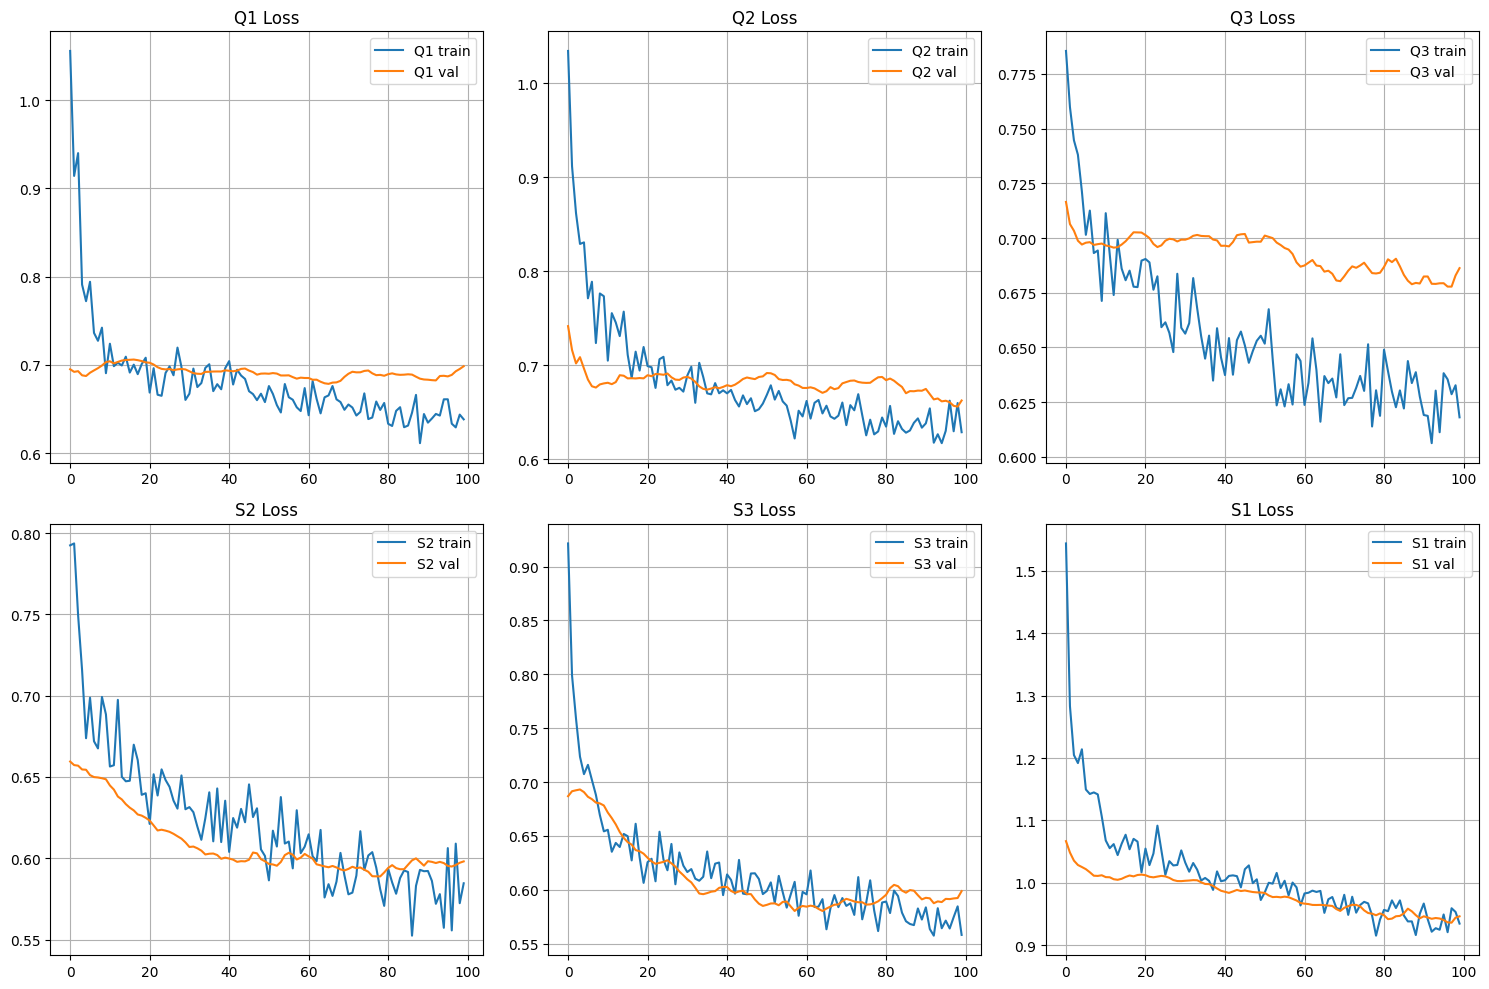

Multi-task Learning 완료!


In [464]:
# ✅ 학습 과정 시각화 (선택사항)
import matplotlib.pyplot as plt

def plot_training_history(history):
    """학습 과정 시각화"""
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    # 각 Task별 loss
    for i, target in enumerate(output_names):
        if i < 6:  # 6개 subplot만 사용
            axes[i].plot(history.history[f'{target}_loss'], label=f'{target} train')
            axes[i].plot(history.history[f'val_{target}_loss'], label=f'{target} val')
            axes[i].set_title(f'{target} Loss')
            axes[i].legend()
            axes[i].grid(True)
    
    plt.tight_layout()
    plt.show()

plot_training_history(history)  # 주석 해제하여 사용

print("Multi-task Learning 완료!")

In [465]:
 
# # 결과 요약 - 특성 중요도 상위 20개 표시
# print("\n===== 주요 특성 중요도 (상위 20개) =====")
# print(feature_importance.head(20))

# # 모델 평가 (검증 데이터가 있는 경우)
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import classification_report, confusion_matrix

# # 검증용 데이터 분리
# X_train, X_val, y_train, y_val = train_test_split(
#     X, y_multi, test_size=0.2, random_state=42, stratify=y_multi
# )